In [1]:
from __future__ import print_function

from selectinf.approx_reference_nbd import *

from __future__ import print_function

import collections
collections.Callable = collections.abc.Callable

import time

from selectinf.Tests.instance import GGM_instance

from selectinf.Tests.nbd_naive_and_ds import *

In [90]:
# TODO: Add root n to the randomization covariance
# Remark: Not needed (?) anymore since X is now scaled
prec,cov,X = GGM_instance(n=500,p=50, max_edges=1)
nbd_instance = nbd_lasso.gaussian(X, n_scaled=False, weights_const=0.45,
                                  ridge_terms=1., randomizer_scale=0.5)
active_signs_nonrandom = nbd_instance.fit(perturb=np.zeros((50,49)))
nonzero_n = nbd_instance.nonzero
active_signs_random = nbd_instance.fit()
nonzero_approx = nbd_instance.nonzero
print(active_signs_nonrandom.shape)
print(np.abs(active_signs_nonrandom).sum())
print(np.abs(active_signs_random).sum())
print(np.abs(prec != 0).sum() - 50)
print("Naive F1:", calculate_F1_score_graph(prec, selection=nonzero_n))
print("Approx F1:", calculate_F1_score_graph(prec, selection=nonzero_approx))

(50, 49)
8.0
9.0
4
Naive F1: 0.5
Approx F1: 0.4444444444444445


In [91]:
parallel_start = time.time()
intervals = nbd_instance.inference(parallel=True)
parallel_stop = time.time()
print("Parallel:", parallel_stop - parallel_start)
print(nonzero_approx.sum())

Parallel: 4.662173748016357
14


In [29]:
serial_start = time.time()
intervals = nbd_instance.inference(parallel=False)
serial_stop = time.time()
print("Serial:", serial_stop - serial_start)
print(nonzero_approx.sum())

Inference for 28 , 39
lb: -0.303975679323357
ub: 0.6727609501383536
Inference for 29 , 33
lb: -0.2860330899005515
ub: 0.620756742404329
Inference for 45 , 47
lb: -0.6244176978717518
ub: 0.2792587741301924
Serial: 0.9264340400695801
6


In [92]:
nonzero = nbd_instance.nonzero

In [93]:
def print_nonzero_intervals(nonzero, intervals, prec, X):
    # Intervals, prec, X are all in their original scale
    n, p = X.shape
    S = X.T @ X / n
    Theta_hat = np.linalg.inv(S)

    for i in range(p):
        for j in range(i+1,p):
            if nonzero[i,j]:
                print("(",i,",",j,")", "selected")
                print("Theta", "(",i,",",j,")", "interval:", intervals[i,j,:])
                print("Theta", "(",i,",",j,")", prec[i,j])
                print("S", "(",i,",",j,")", S[i,j])
                print("Theta_hat", "(",i,",",j,")", Theta_hat[i,j])

In [94]:
print_nonzero_intervals(nonzero, intervals, prec, X)

( 3 , 5 ) selected
Theta ( 3 , 5 ) interval: [-0.08619478  0.18946567]
Theta ( 3 , 5 ) -0.0
S ( 3 , 5 ) 0.1327489547229732
Theta_hat ( 3 , 5 ) -0.15157355855589896
( 10 , 17 ) selected
Theta ( 10 , 17 ) interval: [-0.15918439  0.1796508 ]
Theta ( 10 , 17 ) -0.0
S ( 10 , 17 ) -0.18442865885476314
Theta_hat ( 10 , 17 ) 0.1296940015456008
( 10 , 24 ) selected
Theta ( 10 , 24 ) interval: [-0.16359274  0.19498078]
Theta ( 10 , 24 ) 0.0
S ( 10 , 24 ) -0.16165590495110624
Theta_hat ( 10 , 24 ) 0.07730473001966517
( 10 , 45 ) selected
Theta ( 10 , 45 ) interval: [-0.33732555 -0.3277672 ]
Theta ( 10 , 45 ) -0.792228013339961
S ( 10 , 45 ) 2.1793148296309095
Theta_hat ( 10 , 45 ) -0.8559974551517722
( 19 , 36 ) selected
Theta ( 19 , 36 ) interval: [-0.31821613  0.03934283]
Theta ( 19 , 36 ) 0.0
S ( 19 , 36 ) -0.1553419609550515
Theta_hat ( 19 , 36 ) 0.06784111547762578
( 22 , 36 ) selected
Theta ( 22 , 36 ) interval: [-0.04247506 -0.03685001]
Theta ( 22 , 36 ) -0.7363391063461147
S ( 22 , 36 ) 1

In [95]:
coverage = get_coverage(nonzero, intervals, prec, n=500, p=50, scale=False)
cov_rate = coverage.sum() / (nonzero.sum()/2)
cov_rate

0.7142857142857143

In [143]:
from selectinf.approx_reference_nbd import _approx_log_reference


def approx_inference(query_spec, j0k0, X_n, n, p, ngrid=10000, ncoarse=None, level=0.9):
    j0 = j0k0[0]
    k0 = j0k0[1]
    # X_n: X / sqrt(n)
    S = X_n.T @ X_n

    inner_prod = S[j0,k0] # S = X.T X / n

    S_copy = np.copy(S)
    stat_grid = np.linspace(-5, 5, num=ngrid)

    if ncoarse is not None:
        coarse_grid = np.linspace(-5, 5, ncoarse)
        eval_grid = coarse_grid
    else:
        eval_grid = stat_grid
    ref_hat = _approx_log_reference(query_spec, eval_grid, j0, k0, S_copy, n, p)
    #print("ref_hat shape:", ref_hat.shape)

    def log_det_S_j_k(s_val):
        S_j_k = S_copy
        S_j_k[j0,k0] = s_val
        S_j_k[k0,j0] = s_val
        if np.linalg.det(S_j_k) < 0:
            print("negative det", np.linalg.det(S_j_k),
                  "grid", s_val)
            return -np.inf
        return np.log((np.linalg.det(S_j_k))) * (n-p-1)/2

    if ncoarse is None:
        logWeights = np.zeros((ngrid,))
        for g in range(ngrid):
            #print(logWeights[g])
            #print(log_det_S_j_k(eval_grid[g]))
            #print(ref_hat[g])
            logWeights[g] = log_det_S_j_k(eval_grid[g]) + ref_hat[g]

        # plt.plot(eval_grid, logWeights)

        # normalize logWeights
        logWeights = logWeights - np.max(logWeights)
        # Set extremely small values (< e^-500) to e^-500 for numerical stability
        # logWeights_zero = (logWeights < -500)
        # logWeights[logWeights_zero] = -500
        condlWishart = discrete_family(eval_grid,
                                       np.exp(logWeights),
                                       logweights=logWeights)
    else:
        # print("Coarse grid")
        approx_fn = interp1d(eval_grid,
                             ref_hat,
                             kind='quadratic',
                             bounds_error=False,
                             fill_value='extrapolate')
        grid = np.linspace(-5, 5, num=ngrid)
        logWeights = np.zeros((ngrid,))
        for g in range(ngrid):
            #print(log_det_S_j_k(grid[g]))
            #print(approx_fn(grid[g]))
            logWeights[g] = log_det_S_j_k(grid[g]) + approx_fn(grid[g])

        # plt.plot(grid, logWeights)

        # normalize logWeights
        logWeights = logWeights - np.max(logWeights)
        # Set extremely small values (< e^-500) to e^-500 for numerical stability
        # logWeights_zero = (logWeights < -500)
        # logWeights[logWeights_zero] = -500
        condlWishart = discrete_family(grid, np.exp(logWeights),
                                       logweights=logWeights)

    if np.isnan(logWeights).sum() != 0:
        print("logWeights contains nan")
    elif (logWeights == np.inf).sum() != 0:
        print("logWeights contains inf")
    elif (np.asarray(ref_hat) == np.inf).sum() != 0:
        print("ref_hat contains inf")
    elif (np.asarray(ref_hat) == -np.inf).sum() != 0:
        print("ref_hat contains -inf")
    elif np.isnan(np.asarray(ref_hat)).sum() != 0:
        print("ref_hat contains nan")

    neg_interval = condlWishart.equal_tailed_interval(observed=inner_prod,
                                                      alpha=1-level)
    if np.isnan(neg_interval[0]) or np.isnan(neg_interval[1]):
        print("Failed to construct intervals: nan")

    interval = invert_interval(neg_interval)

    pivot = condlWishart.ccdf(theta=0)

    return condlWishart, logWeights#pivot, interval[0], interval[1], condlWishart

In [144]:
query_spec = nbd_instance.specification

# X is divided by root n, where n is the dimension of X
# The target of inference is n*Theta (n * prec)
X_n = nbd_instance.X_n
n, p = X_n.shape

In [145]:
for i in range(p):
    for j in range(i + 1, p):
        if nonzero[i, j]:
            print("(i,j) = (", i, ",", j, ")")
            print("Theta", prec[i, j])

(i,j) = ( 3 , 5 )
Theta -0.0
(i,j) = ( 10 , 17 )
Theta -0.0
(i,j) = ( 10 , 24 )
Theta 0.0
(i,j) = ( 10 , 45 )
Theta -0.792228013339961
(i,j) = ( 19 , 36 )
Theta 0.0
(i,j) = ( 22 , 36 )
Theta -0.7363391063461147
(i,j) = ( 22 , 46 )
Theta 0.0


In [146]:
n=500
p=50
X_n = X / np.sqrt(n)
S = X_n.T @ X_n

j0=10
k0=45
condlWishart, logWeights = approx_inference(query_spec=query_spec,
                                   j0k0=(j0,k0), X_n=X_n, n=n, p=p,
                                   ngrid=100000, ncoarse=100, level=0.9)
"""neg_interval = condlWishart.equal_tailed_interval(observed=S[j0,k0],
                                                  alpha=1-0.9)
if np.isnan(neg_interval[0]) or np.isnan(neg_interval[1]):
        print("Failed to construct intervals: nan")

interval = invert_interval(neg_interval)
print(np.asarray(interval)/n)"""

negative det -9.006513858037374 grid -5.0
negative det -9.006052969059 grid -4.99989999899999
negative det -9.00559208901597 grid -4.99979999799998
negative det -9.005131217908383 grid -4.99969999699997
negative det -9.004670355736197 grid -4.99959999599996
negative det -9.004209502499442 grid -4.99949999499995
negative det -9.003748658198054 grid -4.99939999399994
negative det -9.003287822832128 grid -4.99929999299993
negative det -9.002826996401586 grid -4.99919999199992
negative det -9.002366178906465 grid -4.99909999099991
negative det -9.001905370346762 grid -4.9989999899999
negative det -9.001444570722454 grid -4.99889998899989
negative det -9.000983780033565 grid -4.99879998799988
negative det -9.000522998280076 grid -4.99869998699987
negative det -9.000062225462027 grid -4.99859998599986
negative det -8.999601461579365 grid -4.99849998499985
negative det -8.999140706632119 grid -4.99839998399984
negative det -8.9986799606203 grid -4.99829998299983
negative det -8.99821922354389

'neg_interval = condlWishart.equal_tailed_interval(observed=S[j0,k0],\n                                                  alpha=1-0.9)\nif np.isnan(neg_interval[0]) or np.isnan(neg_interval[1]):\n        print("Failed to construct intervals: nan")\n\ninterval = invert_interval(neg_interval)\nprint(np.asarray(interval)/n)'

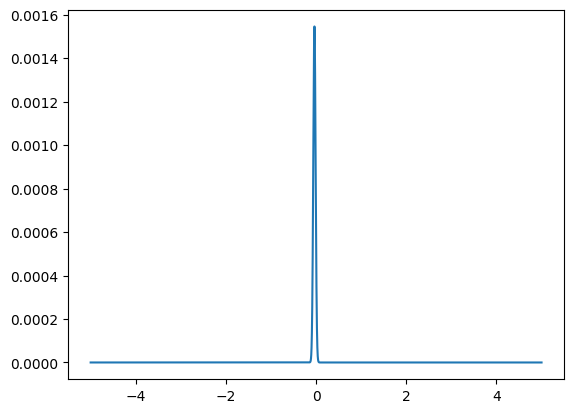

In [147]:
grid = np.linspace(-5, 5, num=100000)
pdf = condlWishart.pdf(theta=prec[j0,k0]*500*1.2)
plt.plot(grid, pdf)

In [148]:
S = X_n.T @ X_n
inner_prod = S[j0,k0]
interval = condlWishart.equal_tailed_interval(observed = inner_prod,
                                              alpha=0.1)

In [149]:
F = lambda th: condlWishart.cdf(th, inner_prod)

In [150]:
print(interval[0]/500, interval[1]/500)

0.6690957560454378 0.8660501467623701


In [139]:
F(-0.792228013339961*500)

1.0

In [140]:
F(-0.692228013339961 * 500)

0.9999999999999999

In [142]:
np.min(condlWishart._lw)

-20192.492943150028

In [74]:
np.isnan(logWeights).sum()

0

In [46]:
print(logWeights)

[-4.31428421e+04 -4.29746583e+04 -4.28068035e+04 -4.26392775e+04
 -4.24720804e+04 -4.23052122e+04 -4.21386729e+04 -4.19724626e+04
 -4.18065811e+04 -4.16410287e+04 -4.14758051e+04 -4.13109106e+04
 -4.11463450e+04 -4.09821084e+04 -4.08182007e+04 -4.06546221e+04
 -4.04913725e+04 -4.03284519e+04 -4.01658603e+04 -4.00035978e+04
 -3.98416643e+04 -3.96800599e+04 -3.95187846e+04 -3.93578383e+04
 -3.91972212e+04 -3.90369331e+04 -3.88769742e+04 -3.87173444e+04
 -3.85580437e+04 -3.83990722e+04 -3.82404298e+04 -3.80821166e+04
 -3.79241326e+04 -3.77664777e+04 -3.76091521e+04 -3.74521557e+04
 -3.72954885e+04 -3.71391506e+04 -3.69831419e+04 -3.68274625e+04
 -3.66721123e+04 -3.65170915e+04 -3.63623999e+04 -3.62080377e+04
 -3.60540048e+04 -3.59003012e+04 -3.57469269e+04 -3.55938821e+04
 -3.54411666e+04 -3.52887804e+04 -3.51367237e+04 -3.49849964e+04
 -3.48335986e+04 -3.46825301e+04 -3.45317912e+04 -3.43813817e+04
 -3.42313016e+04 -3.40815511e+04 -3.39321301e+04 -3.37830386e+04
 -3.36342766e+04 -3.34858

In [56]:
print(condlWishart._pdf)

[1.77951522e-109 1.27823144e-109 9.17744111e-110 ... 3.00690009e-288
 4.09513015e-288 5.57294707e-288]


In [57]:
print(condlWishart._partition)

390.3598516107452


In [58]:
_thetaX = logWeights
_largest = _thetaX.max() # - 10  # try to avoid over/under flow, 10 seems arbitrary
_exp_thetaX = np.exp(_thetaX - _largest)
if np.isnan(_exp_thetaX).sum() != 0:
    print("Normalized pdf is nan")
    min_log_order = np.min(_thetaX) - _largest
    max_log_order = np.max(_thetaX) - _largest
    print("Min log order:", min_log_order)
    print("Min _thetaX:", np.min(_thetaX))
    print("Min log weights:", np.min(logWeights))
    print("Max log order:", max_log_order)
    print("# nan in _thetaX:", np.isnan(_thetaX).sum())

In [59]:
print(np.exp(logWeights - np.max(logWeights)))

[6.94651295e-107 4.98970235e-107 3.58250455e-107 ... 1.17377307e-285
 1.59857440e-285 2.17545479e-285]


In [60]:
print((logWeights))

[ -993.79644559  -994.12730914  -994.45862324 ... -1405.43460854
 -1405.12571972 -1404.81759421]


In [61]:
print(_thetaX)

[ -993.79644559  -994.12730914  -994.45862324 ... -1405.43460854
 -1405.12571972 -1404.81759421]


In [62]:
_partition

390.3598516107452

In [63]:
neg_interval = condlWishart.equal_tailed_interval(observed=S[j0,k0],
                                                  alpha=1-0.9)
if np.isnan(neg_interval[0]) or np.isnan(neg_interval[1]):
        print("Failed to construct intervals: nan")

interval = invert_interval(neg_interval)
print(np.asarray(interval)/n)

[-0.05706718  0.15567682]
